### Курсовой проект

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img

# plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold

import catboost as catb

from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import chi2_contingency

# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

from pathlib import Path
import pickle
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = 50

In [3]:
matplotlib.rcParams.update({'font.size': 12})

In [4]:
# Метрики
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
        
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
# Важность призников
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def balance_df_by_target(df, target_name, method='over'):
    """Функция балансировки данных обучающего и тестового датасетов"""

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

**Признаки в данных**

***Пути к директориям и файлам***

In [9]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [10]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH,sep=',')

In [11]:
train_df.sample(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1721,Own Home,NaN,10+ years,0.0,13.0,28.5,575872.0,0.0,15.0,0.0,debt consolidation,Short Term,257774.0,223801.0,8939.0,NaN,0
2037,Rent,NaN,1 year,0.0,13.0,12.7,342650.0,0.0,NaN,0.0,debt consolidation,Short Term,175802.0,202711.0,11915.0,NaN,0
3980,Home Mortgage,1700633.0,2 years,0.0,17.0,23.4,1172314.0,0.0,34.0,0.0,debt consolidation,Short Term,99999999.0,654037.0,38831.0,740.0,0
6308,Rent,1053056.0,2 years,0.0,10.0,8.0,399014.0,0.0,22.0,0.0,debt consolidation,Long Term,478852.0,162298.0,20973.0,711.0,0
3244,Home Mortgage,1126434.0,10+ years,0.0,8.0,28.5,281182.0,0.0,NaN,0.0,home improvements,Short Term,260854.0,37145.0,6796.0,744.0,0
688,Rent,950665.0,< 1 year,0.0,15.0,15.1,1082796.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,492822.0,22658.0,744.0,0
3559,Home Mortgage,2093572.0,4 years,0.0,16.0,14.8,963248.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,366035.0,24948.0,740.0,0
3937,Rent,747232.0,2 years,0.0,4.0,18.4,207702.0,0.0,34.0,0.0,debt consolidation,Short Term,173052.0,147098.0,6850.0,732.0,0
2728,Rent,1080492.0,2 years,0.0,19.0,13.0,592174.0,0.0,5.0,0.0,major purchase,Short Term,201080.0,185136.0,15667.0,744.0,0
7354,Home Mortgage,1334066.0,7 years,0.0,14.0,19.6,1430968.0,0.0,NaN,0.0,debt consolidation,Long Term,623788.0,1160444.0,31573.0,6640.0,1


In [12]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


In [13]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [14]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [15]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [16]:
# Целевая переменная
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обработка пропусков

In [17]:
# Рассмотрим признак Home Ownership (Домовладение)
train_df['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [18]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [19]:
# Имеем 4 занчения по данному признаку. Преобразуем их в категории
train_df['Home Ownership'] = train_df['Home Ownership'].replace({'Own Home': 2,\
                                                     'Home Mortgage': 0,\
                                                     'Rent': 1,\
                                                     'Have Mortgage': 3})

In [20]:
train_df.sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2809,0,1470448.0,< 1 year,0.0,18.0,19.0,669680.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,333716.0,28674.0,743.0,0
969,1,1282956.0,10+ years,0.0,8.0,17.0,607508.0,0.0,39.0,0.0,debt consolidation,Long Term,436920.0,340518.0,11440.0,713.0,1
4435,0,1035177.0,3 years,0.0,11.0,15.4,662002.0,0.0,NaN,0.0,home improvements,Long Term,528484.0,277856.0,21911.0,730.0,1
7035,1,NaN,1 year,0.0,5.0,12.7,734096.0,0.0,NaN,0.0,other,Short Term,77286.0,39311.0,2308.0,NaN,1
727,0,2105656.0,7 years,0.0,11.0,17.0,1109614.0,0.0,NaN,0.0,debt consolidation,Short Term,435380.0,307610.0,48957.0,750.0,0


In [21]:
# Проверим пропуски
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [22]:
# Имеются пропуски Annual Income (Годовой доход). 
# Отметим их созданием признака Annual Income_nan и заполним  0
train_df['Annual Income_nan'] = 0

In [23]:
# Теперь заполним там где есть пропуски = 1
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income_nan'] = 1

In [24]:
# Заменим пропуски Annual Income (Годовой доход) медианной
train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()

In [25]:
# Рассмотрим Years in current job (Стаж на текущей работе)
train_df['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [26]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [27]:
# Имеются пропуски 371 
train_df['Years in current job'].isna().sum()

371

In [28]:
# Отметим их созданием признака Years in current job_nan и запалним пока 0
train_df['Years in current job_nan'] = 0

In [29]:
# Теперь заполним там где есть пропуски = 1
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job_nan'] = 1

In [30]:
# Подсчитаем моду для данного призника и заполним ей пропуски
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job'] =\
                                         train_df['Years in current job'].mode()[0]

In [31]:
train_df['Years in current job'].isna().sum()

0

In [32]:
train_df['Years in current job'].value_counts().sort_index()

1 year        504
10+ years    2703
2 years       705
3 years       620
4 years       469
5 years       516
6 years       426
7 years       396
8 years       339
9 years       259
< 1 year      563
Name: Years in current job, dtype: int64

In [33]:
# Years in current job преобразуем их в категории (в стаж в годах)
train_df['Years in current job'] =\
train_df['Years in current job'].replace({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,\
                                         '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,\
                                         '8 years': 8, '9 years': 9, '10+ years': 10})

In [34]:
# Проверим все ли заполнилось
train_df['Years in current job'].value_counts().sort_index()

0      563
1      504
2      705
3      620
4      469
5      516
6      426
7      396
8      339
9      259
10    2703
Name: Years in current job, dtype: int64

In [35]:
# Рассмотрим признак Tax Liens - Залог (Налоговое право удержание)
# Пока не понятно, что за категории от 0 до 7
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [36]:
# Рассмотрим признак Number of Credit Problems (Количество проблем с кредитом)
# Также прка не понятно, что за категории от 0 до 7
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [37]:
# Рассмотрим признак Months since last delinquent (Кол-во месяцев с послед. просрочки платежа) 
train_df['Months since last delinquent'].isna().sum()

4081

In [38]:
# Отметим их созданием признака Months since last delinquent_nan и запалним пока 0
train_df['Months since last delinquent_nan'] = 0

In [39]:
# Теперь заполним там где есть пропуски = 1
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent_nan'] = 1

In [40]:
train_df[train_df['Months since last delinquent_nan'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan
6,0,1511108.0,10,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0,0,0,0
7,1,1040060.0,10,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1,0,0,0
9,0,1168386.0,1,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1,1,0,0
18,0,1401744.0,2,0.0,9.0,29.0,387222.0,0.0,40.0,0.0,debt consolidation,Long Term,553586.0,201989.0,13434.0,695.0,1,0,0,0
20,0,1651993.0,10,0.0,11.0,26.5,663894.0,0.0,44.0,0.0,debt consolidation,Long Term,585090.0,252852.0,8742.0,697.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,0,1394942.0,10,0.0,15.0,27.2,1441396.0,0.0,35.0,0.0,debt consolidation,Short Term,753764.0,496698.0,16972.0,742.0,1,0,0,0
7490,2,1368000.0,10,0.0,20.0,26.7,897842.0,0.0,69.0,0.0,debt consolidation,Short Term,683650.0,517199.0,29868.0,688.0,1,0,0,0
7491,0,2833185.0,6,0.0,18.0,21.3,280170.0,0.0,6.0,0.0,debt consolidation,Short Term,437404.0,108889.0,61150.0,704.0,0,0,0,0
7493,1,1257610.0,8,0.0,14.0,16.5,821480.0,0.0,58.0,0.0,debt consolidation,Long Term,448052.0,167428.0,27562.0,676.0,1,0,0,0


In [41]:
# Пока будем считать, что пустые значения это клиенты, которые не имеют правонарушений и равны = 0
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [42]:
# Рассмотрим призанк Bankruptcies (Банкрот)
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [43]:
# пропуски
train_df['Bankruptcies'].isna().sum()

14

In [44]:
# Так как большенсво значений имеют 0, 
# а кол-во пропущ. пропусков всего = 14 буду счтитать их модой
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [45]:
# Рассмотрим признак Purpose (цель кредита)
train_df['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [46]:
# Призник цель кредита Purpose
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [47]:
# Purpose преобразуем  в категории (цель кредита)
train_df['Purpose'] =\
train_df['Purpose'].replace({'debt consolidation': 0, 'other': 1, 'home improvements': 2, 'business loan': 3,\
                                         'buy a car': 4, 'medical bills': 5, 'major purchase': 6, 'take a trip': 7,\
                                         'buy house': 8, 'small business': 9, 'wedding': 10, 'moving': 11,\
                                         'educational expenses': 12, 'vacation': 13, 'renewable energy': 14})

In [48]:
# Рассмотрим признак Term (срок кредита)
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [49]:
# Переведем в бинарный признак (срок кредита)
train_df['Term'] = train_df['Term'].replace({'Short Term': 0, 'Long Term': 1})

In [50]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan
0,2,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,0,0,99999999.0,47386.0,7914.0,749.0,0,0,1,1
1,2,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,0,1,264968.0,394972.0,18373.0,737.0,1,0,0,1
2,0,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,0,0,99999999.0,308389.0,13651.0,742.0,0,0,0,1
3,2,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,0,0,121396.0,95855.0,11338.0,694.0,0,0,0,1
4,1,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,0,0,125840.0,93309.0,7180.0,719.0,0,0,0,1


In [51]:
train_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.604533,1.325286e+06,6.084133,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,0.552400,0.259200,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733,0.207600,0.049467,0.544133
std,0.649047,7.567551e+05,3.640717,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,1.551293,0.438225,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874,0.405616,0.216855,0.498082
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,0.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# В признаке Credit Score имеются пропуски в колич-ве 1557 
train_df['Credit Score'].isna().sum()

1557

In [53]:
# Создадим нвоый признак Credit Score_nan и заполним его 0 
train_df['Credit Score_nan'] = 0

In [54]:
# Где есть пропуски подставим 1 
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score_nan'] = 1


In [55]:
# Исходя из знаний предметной области, понимаем что 
# Credit Score не может быть < 300 и > 900 Пока что заполняем случайно от 580 до 740
# Возмоно будет замена на медиану
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = \
train_df['Credit Score'].apply(lambda x: random.randrange(580, 740))

In [56]:
train_df['Credit Score'].isna().sum()

0

In [57]:
train_df.isna().sum()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent        0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Credit Default                      0
Annual Income_nan                   0
Years in current job_nan            0
Months since last delinquent_nan    0
Credit Score_nan                    0
dtype: int64

### Обработаем выбросы

In [58]:
# Исходя из знаний предметной области, понимаем что Credit Score не может быть < 300 и > 900
train_df['Credit Score'].sort_values().unique()

array([ 580.,  581.,  582.,  583.,  584.,  585.,  586.,  587.,  588.,
        589.,  590.,  591.,  592.,  593.,  594.,  595.,  596.,  597.,
        598.,  599.,  600.,  601.,  602.,  603.,  604.,  605.,  606.,
        607.,  608.,  609.,  610.,  611.,  612.,  613.,  614.,  615.,
        616.,  617.,  618.,  619.,  620.,  621.,  622.,  623.,  624.,
        625.,  626.,  627.,  628.,  629.,  630.,  631.,  632.,  633.,
        634.,  635.,  636.,  637.,  638.,  639.,  640.,  641.,  642.,
        643.,  644.,  645.,  646.,  647.,  648.,  649.,  650.,  651.,
        652.,  653.,  654.,  655.,  656.,  657.,  658.,  659.,  660.,
        661.,  662.,  663.,  664.,  665.,  666.,  667.,  668.,  669.,
        670.,  671.,  672.,  673.,  674.,  675.,  676.,  677.,  678.,
        679.,  680.,  681.,  682.,  683.,  684.,  685.,  686.,  687.,
        688.,  689.,  690.,  691.,  692.,  693.,  694.,  695.,  696.,
        697.,  698.,  699.,  700.,  701.,  702.,  703.,  704.,  705.,
        706.,  707.,

In [59]:
# Все что больше 900 поделим на 10
train_df.loc[train_df['Credit Score'] > 900, 'Credit Score'] = \
train_df['Credit Score'] / 10

In [60]:
train_df['Credit Score'].sort_values().unique()

array([580., 581., 582., 583., 584., 585., 586., 587., 588., 589., 590.,
       591., 592., 593., 594., 595., 596., 597., 598., 599., 600., 601.,
       602., 603., 604., 605., 606., 607., 608., 609., 610., 611., 612.,
       613., 614., 615., 616., 617., 618., 619., 620., 621., 622., 623.,
       624., 625., 626., 627., 628., 629., 630., 631., 632., 633., 634.,
       635., 636., 637., 638., 639., 640., 641., 642., 643., 644., 645.,
       646., 647., 648., 649., 650., 651., 652., 653., 654., 655., 656.,
       657., 658., 659., 660., 661., 662., 663., 664., 665., 666., 667.,
       668., 669., 670., 671., 672., 673., 674., 675., 676., 677., 678.,
       679., 680., 681., 682., 683., 684., 685., 686., 687., 688., 689.,
       690., 691., 692., 693., 694., 695., 696., 697., 698., 699., 700.,
       701., 702., 703., 704., 705., 706., 707., 708., 709., 710., 711.,
       712., 713., 714., 715., 716., 717., 718., 719., 720., 721., 722.,
       723., 724., 725., 726., 727., 728., 729., 73

In [61]:
train_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.604533,1.325286e+06,6.084133,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,0.552400,0.259200,1.187318e+07,2.898332e+05,18314.454133,707.735333,0.281733,0.207600,0.049467,0.544133,0.207600
std,0.649047,7.567551e+05,3.640717,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,1.551293,0.438225,3.192612e+07,3.178714e+05,11926.764673,40.371682,0.449874,0.405616,0.216855,0.498082,0.405616
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,580.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,689.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,722.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,0.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,738.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
#Создадим новый признак Maximum Open Credit_outlier заполним его 0
train_df['Maximum Open Credit_outlier'] = 0

In [63]:
#Maximum Open Credit
#Найдем выбросу с помощью квантилей. Наблюдения, значения которых больше 97,5% квантиля
#и которые меньше 2,5% квантиля будем считать выбросами

In [64]:
#Определим максимальное значение для Maximum Open Credit
maximum_open_credit_max_value = np.quantile(train_df['Maximum Open Credit'], q=0.975)
maximum_open_credit_max_value

2236204.2999999984

In [65]:
#Определим минимальное значение для Maximum Open Credit
maximum_open_credit_min_value = np.quantile(train_df['Maximum Open Credit'], q=0.025)
maximum_open_credit_min_value

70912.60000000002

In [66]:
#Посмотрим сколько наблюдений попало в выборку
condition = (train_df['Maximum Open Credit'] > maximum_open_credit_max_value) | \
(train_df['Maximum Open Credit'] < maximum_open_credit_min_value)
train_df[condition]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Maximum Open Credit_outlier
8,0,1168386.0,5,0.0,17.0,15.7,0.0,1.0,0.0,1.0,2,0,129734.0,19.0,17.0,692.0,0,1,0,1,1,0
44,3,1334256.0,10,0.0,17.0,15.4,380052288.0,1.0,35.0,0.0,7,0,33110.0,656450.0,34357.0,729.0,0,0,0,0,0,0
57,1,719549.0,2,0.0,7.0,16.3,37290.0,1.0,0.0,0.0,0,1,71258.0,27569.0,12592.0,722.0,1,0,0,1,0,0
75,2,1168386.0,10,0.0,17.0,32.5,2322650.0,0.0,0.0,0.0,1,0,448184.0,136401.0,29320.0,712.0,0,1,0,1,1,0
85,0,1301614.0,9,0.0,17.0,18.0,9339924.0,0.0,0.0,0.0,0,0,592240.0,959899.0,16813.0,748.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,0,1100670.0,6,0.0,11.0,19.9,57134.0,0.0,17.0,0.0,1,0,142824.0,41135.0,18987.0,692.0,0,0,0,0,0,0
7433,1,2011758.0,0,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,4,1,106480.0,18791.0,12590.0,606.0,1,0,0,0,0,0
7441,1,1406836.0,1,0.0,12.0,22.6,2383260.0,0.0,0.0,0.0,0,0,99999999.0,461054.0,7386.0,747.0,0,0,0,1,0,0
7473,2,1644070.0,10,0.0,15.0,33.5,4262654.0,0.0,0.0,0.0,0,0,87516.0,2256687.0,30963.0,737.0,0,0,0,1,0,0


In [67]:
# Отметим выборсы = 1
train_df.loc[condition, 'Maximum Open Credit_outlier'] = 1

In [68]:
# Заполним выбросы медианой
train_df.loc[condition, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

In [69]:
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     5.817764e+05
std      3.983164e+05
min      7.123600e+04
25%      2.989635e+05
50%      4.781590e+05
75%      7.502330e+05
max      2.234056e+06
Name: Maximum Open Credit, dtype: float64

In [70]:
#Current Loan Amount
#Найдем выбросу с помощью квантилей. Наблюдения, значения которых больше 97,5% квантиля
#будем считать выбросами

In [71]:
# Создадим новый призник Current Loan Amount_outlier и заполним его 0
train_df['Current Loan Amount_outlier'] = 0

In [72]:
#Определим максимальное значение для Current Loan Amount
сurrent_loan_amount_max_value = np.quantile(train_df['Current Loan Amount'], q=0.975)
сurrent_loan_amount_max_value

99999999.0

In [73]:
#Посмотрим сколько наблюдений попало в выборку
condition = (train_df['Current Loan Amount'] >= сurrent_loan_amount_max_value)
train_df[condition]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Maximum Open Credit_outlier,Current Loan Amount_outlier
0,2,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,0,0,99999999.0,47386.0,7914.0,749.0,0,0,1,1,0,0,0
2,0,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,0,0,99999999.0,308389.0,13651.0,742.0,0,0,0,1,0,0,0
6,0,1511108.0,10,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,2,0,99999999.0,51623.0,2317.0,745.0,0,0,0,0,0,0,0
22,1,463790.0,10,0.0,6.0,28.3,288442.0,0.0,0.0,0.0,0,0,99999999.0,157700.0,5063.0,738.0,0,0,1,1,0,0,0
27,1,1004055.0,8,0.0,7.0,14.5,328394.0,0.0,0.0,0.0,0,0,99999999.0,195966.0,6041.0,734.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,1,1406836.0,1,0.0,12.0,22.6,478159.0,0.0,0.0,0.0,0,0,99999999.0,461054.0,7386.0,747.0,0,0,0,1,0,1,0
7445,0,1564384.0,6,0.0,21.0,17.3,1545016.0,0.0,0.0,0.0,1,1,99999999.0,1043442.0,32461.0,728.0,0,0,0,1,0,0,0
7464,0,1159152.0,6,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,0,0,99999999.0,49438.0,18257.0,737.0,0,0,0,0,0,0,0
7475,1,848426.0,10,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,0,0,99999999.0,83638.0,16473.0,742.0,0,0,0,0,0,0,0


In [74]:
# Отметим выборсы = 1
train_df.loc[condition, 'Current Loan Amount_outlier'] = 1

In [75]:
# Заполним выбросы медианой
train_df.loc[condition, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

In [76]:
# Создадим новый призник Current Credit Balance_outlier и заполним его 0
train_df['Current Credit Balance_outlier'] = 0

In [77]:
#MCurrent Credit Balanc
#Найдем выбросу с помощью квантилей. Наблюдения, значения которых больше 97,5% квантиля
#и которые меньше 2,5% квантиля будем считать выбросами

In [78]:
#Определим максимальное значение для Current Credit Balance
current_credit_balance_max_value = np.quantile(train_df['Current Credit Balance'], q=0.975)
current_credit_balance_max_value

1001579.7749999975

In [79]:
#Определим максимальное значение для Current Credit Balance
current_credit_balance_min_value = np.quantile(train_df['Current Credit Balance'], q=0.025)
current_credit_balance_min_value

11970.0

In [80]:
#Посмотрим сколько наблюдений попало в выборку
condition = (train_df['Current Credit Balance'] > current_credit_balance_max_value) | \
(train_df['Current Credit Balance'] < current_credit_balance_min_value)
train_df[condition]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Maximum Open Credit_outlier,Current Loan Amount_outlier,Current Credit Balance_outlier
8,0,1168386.0,5,0.0,17.0,15.7,478159.0,1.0,0.0,1.0,2,0,129734.0,19.0,17.0,692.0,0,1,0,1,1,1,0,0
13,1,2066364.0,10,0.0,11.0,17.7,1654026.0,0.0,0.0,0.0,0,1,549780.0,1037077.0,21869.0,728.0,1,0,0,1,0,0,0,0
14,2,2258796.0,7,0.0,11.0,17.7,1602546.0,0.0,0.0,0.0,1,0,185262.0,1374327.0,58352.0,748.0,0,0,0,1,0,0,0,0
25,1,1353142.0,10,0.0,3.0,29.8,1231912.0,0.0,0.0,0.0,1,0,108042.0,1036279.0,22225.0,720.0,0,0,0,1,0,0,0,0
56,1,1520969.0,10,0.0,7.0,19.2,458590.0,0.0,0.0,0.0,2,0,468138.0,2774.0,12865.0,748.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7442,0,1168386.0,3,0.0,8.0,9.1,186054.0,0.0,0.0,0.0,1,0,112596.0,7543.0,17590.0,646.0,0,1,0,1,1,0,0,0
7445,0,1564384.0,6,0.0,21.0,17.3,1545016.0,0.0,0.0,0.0,1,1,309573.0,1043442.0,32461.0,728.0,0,0,0,1,0,0,1,0
7459,0,1168386.0,9,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,0,0,458854.0,1149614.0,85030.0,664.0,0,1,0,0,1,0,0,0
7473,2,1644070.0,10,0.0,15.0,33.5,478159.0,0.0,0.0,0.0,0,0,87516.0,2256687.0,30963.0,737.0,0,0,0,1,0,1,0,0


In [81]:
# Отметим выборсы = 1
train_df.loc[condition, 'Current Credit Balance_outlier'] = 1

In [82]:
# Заполним выбросы медианой
train_df.loc[condition, 'Current Credit Balance'] = train_df['Current Credit Balance'].median()

In [83]:
train_df['Current Credit Balance'].describe()

count      7500.000000
mean     258973.176800
std      189854.014316
min       11970.000000
25%      122564.250000
50%      209323.000000
75%      338314.000000
max      997899.000000
Name: Current Credit Balance, dtype: float64

In [84]:
train_df[train_df['Monthly Debt'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Maximum Open Credit_outlier,Current Loan Amount_outlier,Current Credit Balance_outlier
780,0,867749.0,10,0.0,2.0,16.5,478159.0,0.0,66.0,0.0,2,0,75350.0,209323.0,0.0,704.0,0,0,0,0,0,1,0,1
1643,1,1168386.0,9,0.0,3.0,10.0,478159.0,0.0,0.0,0.0,1,0,332156.0,209323.0,0.0,734.0,1,1,0,1,1,1,0,1
3219,0,1168386.0,10,0.0,3.0,18.5,478159.0,0.0,0.0,0.0,0,0,79200.0,209323.0,0.0,681.0,0,1,0,1,1,1,0,1
3496,1,233567.0,1,0.0,7.0,11.7,478159.0,0.0,0.0,0.0,12,0,210166.0,209323.0,0.0,746.0,0,0,0,0,0,1,0,1
4165,1,1254513.0,10,0.0,6.0,23.4,478159.0,0.0,60.0,0.0,7,0,309573.0,209323.0,0.0,748.0,0,0,0,0,0,1,1,1
7124,1,1168386.0,1,0.0,4.0,11.0,478159.0,0.0,50.0,0.0,0,0,134024.0,209323.0,0.0,620.0,0,1,0,0,1,1,0,1


In [85]:
# Создадим новый призник Monthly Debt_outlier и заполним его 0
train_df['Monthly Debt_outlier'] = 0

In [86]:
# В признике Monthly Debt_outlier где 'Monthly Debt' == 0 заполним его 1
train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt_outlier'] = 1

In [87]:
#В признаке Monthly Debt == 0 будем считать выбросами - заменим на медиану
train_df.loc[train_df['Monthly Debt'] == 0, 'Monthly Debt'] = \
train_df['Monthly Debt'].median()

In [88]:
train_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Maximum Open Credit_outlier,Current Loan Amount_outlier,Current Credit Balance_outlier,Monthly Debt_outlier
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.604533,1.325286e+06,6.084133,0.030133,11.130933,18.317467,5.817764e+05,0.170000,15.815200,0.116933,0.552400,0.259200,309088.029067,258973.176800,18327.315333,707.735333,0.281733,0.207600,0.049467,0.544133,0.207600,0.050133,0.116000,0.050000,0.000800
std,0.649047,7.567551e+05,3.640717,0.271604,4.908924,7.041946,3.983164e+05,0.498598,22.649441,0.346904,1.551293,0.438225,171393.740131,189854.014316,11915.669777,40.371682,0.449874,0.405616,0.216855,0.498082,0.405616,0.218235,0.320246,0.217959,0.028275
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,7.123600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,11242.000000,11970.000000,17.000000,580.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.989635e+05,0.000000,0.000000,0.000000,0.000000,0.000000,180169.000000,122564.250000,10102.750000,689.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,309567.500000,209323.000000,16077.250000,722.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.502330e+05,0.000000,29.000000,0.000000,0.000000,1.000000,396929.500000,338314.000000,23818.000000,738.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,2.234056e+06,7.000000,118.000000,4.000000,14.000000,1.000000,789030.000000,997899.000000,136679.000000,751.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*** Создадим классы для обработки датасета ***

*** PassProcessing ***

In [89]:
class PassProcessing():
    """Обработка пропусков"""
    
    def __init__(self):
        # медианы
        self.annual_income_medians = None
        
        # моды
        self.years_in_current_job_mode = None
        self.bankruptcies_mode = None
        
        
    def fit(self, X):
        '''Сохранение статистик'''
        # Расчет медиан
        self.annual_income_medians = X['Annual Income'].median()
        self.years_in_current_job_mode = X['Years in current job'].mode()[0]
        self.bankruptcies_mode = X['Bankruptcies'].mode()[0]
    
    def transform(self, X):
        '''Трансформация данных'''
        
        # Annual Income (Годовой доход)
        X['Annual Income_nan'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income_nan'] = 1
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.annual_income_medians

        # Years in current job (Текущий стаж)
        X['Years in current job_nan'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job_nan'] = 1
        X.loc[X['Years in current job'].isna(), 'Years in current job'] =\
                                                self.years_in_current_job_mode
        
        # Months since last delinquent (Кол-во месяцев с послед. просрочки платежа)
        X['Months since last delinquent_nan'] = 0
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent_nan'] = 1
          # Пока будем считать, что пустые значения это клиенты, которые не имеют 
          # правонарушений и равны = 0
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
        
        # Bankruptcies (Банкротcтва)
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.bankruptcies_mode
        
        # Credit Score (Кредитный рейтинг)
        X['Credit Score_nan'] = 0
        X.loc[X['Credit Score'].isna(), 'Credit Score_nan'] = 1
        
#      Исходя из знаний предметной области, понимаем что, 
#      Credit Score не может быть < 300 и > 900 заполняем случайно от 580 до 740

#         X.loc[X['Credit Score'].isna(), 'Credit Score'] =\
#         X['Credit Score'].apply(lambda x: random.randrange(585, 751))
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = X['Credit Score'].median()
    
        return X

*** FeatureGenetator ***

In [90]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.cat_to_home_ownership_start = None
        self.cat_years_in_current_job_start = None
        self.cat_purpose_start = None
        self.bin_term = None
        
    def fit(self, X):
        '''Категориальные признаки'''
        # Home Ownership
        self.cat_to_home_ownership_start =\
        {'Own Home': 2,'Home Mortgage': 0, 'Rent': 1, 'Have Mortgage': 3}
        
        # Years in current job
        self.cat_years_in_current_job_start =\
        {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,\
        '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,\
        '8 years': 8, '9 years': 9, '10+ years': 10}
        
        # Purpose
        self.cat_purpose_start =\
        {'debt consolidation': 0, 'other': 1, 'home improvements': 2, 'business loan': 3,\
        'buy a car': 4, 'medical bills': 5, 'major purchase': 6, 'take a trip': 7,\
        'buy house': 8, 'small business': 9, 'wedding': 10, 'moving': 11,\
        'educational expenses': 12, 'vacation': 13, 'renewable energy': 14}
        
        # Term
        self.bin_term = {'Short Term': 0, 'Long Term': 1}

        
    def transform(self, X):
        '''Трансформация данных'''
        
        # Home Ownership
        X['Home Ownership'] = X['Home Ownership'].replace(self.cat_to_home_ownership_start)
    
        # Years in current job преобразуем их в категории (в стаж в годах)
        X['Years in current job'] =\
        X['Years in current job'].replace(self.cat_years_in_current_job_start)

        # Purpose (Цель кредита) преобразуем строки в категории
        X['Purpose'] =\
        X['Purpose'].replace(self.cat_purpose_start)

        # Term (срок кредита) Переведем в бинарный признак 
        X['Term'] = X['Term'].replace(self.bin_term)
        
        # Credit Score
        # Создадим категории Credit Score
        X['Credit Score_cat'] = 0

        X.loc[(X['Credit Score'] > 300) & (X['Credit Score'] <= 500),'Credit Score_cat'] = 0
        X.loc[(X['Credit Score'] > 500) & (X['Credit Score'] <= 600),'Credit Score_cat'] = 1
        X.loc[(X['Credit Score'] > 600) & (X['Credit Score'] <= 680),'Credit Score_cat'] = 2
        X.loc[(X['Credit Score'] > 680) & (X['Credit Score'] <= 720),'Credit Score_cat'] = 3
        X.loc[(X['Credit Score'] > 720) & (X['Credit Score'] <= 900),'Credit Score_cat'] = 4      
            
        return X

*** FeatureGenetator ***

In [91]:
class FeatureGenetatorHIQ():
    """Обработка категор. признаков по критер Хи квадрат +++"""
    
    def __init__(self):
        self.cat_to_home_ownership_final = None
        self.cat_years_in_current_job_final = None
        self.cat_tax_liens = None
        self.cat_number_of_credit_problems = None
        self.cat_bankruptcies = None
        self.cat_purpose_final = None
        
        
    def fit(self, X):
        '''Категориальные признаки'''
        # Home Ownership
        self.cat_to_home_ownership_final =\
        {2: 1, 1: 0, 3: 1}
        
        # Years in current job
        self.cat_years_in_current_job_final =\
        {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2, 10: 3}
        
        # Tax Liens 
        self.cat_tax_liens = {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2}
        
        # Number of Credit Problems
        self.cat_number_of_credit_problems = {1: 0, 2: 1, 3: 1, 4: 2, 5: 1, 6: 3, 7: 3}
        
        # Bankruptcies
        self.cat_bankruptcies = {1: 0, 3: 0, 4: 0, 2: 1}
        
        # Purpose
        self.cat_purpose_final =\
        {2: 0, 4: 0, 6: 0, 7: 0, 8: 0, 10: 0, 11: 0, 12: 0, 13:0, 3: 2, 5: 1, 9: 3, 14: 4}
    
    def transform(self, X):
        '''Трансформация данных'''
        
        # Home Ownership
        X['Home Ownership'] = X['Home Ownership'].replace(self.cat_to_home_ownership_final)
    
        # По признаку Years in current job не представляется возможным
        # произвести объединение по Хи квадрат, применим логическое распределение 
        # 0 - 1 лет = 0 кат; 2 - 5 лет = 1 кат; 6 - 9 лет = 2 кат ; 10 = 3 кат
        X['Years in current job'] =\
        X['Years in current job'].replace(self.cat_years_in_current_job_final)
        
        # Tax Liens (Налоговое обременение) cогласно оценки критерий Хи-квадрат Пирсона
        # можем обеденить след категории:  0кат = 0 + 1; 1кат = 2 + 3 + 4 + 5; 2кат = 6 + 7   
        X['Tax Liens'] = X['Tax Liens'].replace(self.cat_tax_liens)
        
        # Number of Credit Problems (Количество проблем с кредитом) cогласно оценки критерий 
        # Хи-квадрат Пирсона можем обеденить след категории:
        # 0кат = 0 + 1; 1кат = 2 + 3 + 5; 2кат = 4; 2кат = 4; 3кат = 6+7;
        X['Number of Credit Problems'] =\
        X['Number of Credit Problems'].replace(self.cat_number_of_credit_problems)
        
        # Bankruptcies (Банкротства) cогласно оценки критерий 
        # Хи-квадрат Пирсона можем обеденить след категории:
        # 0кат = 1 + 3 + 4 ; 1кат = 2; 
        X['Bankruptcies'] = X['Bankruptcies'].replace(self.cat_bankruptcies)
                
        # Purpose (Цель кредита) cогласно оценки критерий 
        # Хи-квадрат Пирсона можем обеденить след категории:
        # 0кат = 2 + 4 + 6 + 7 + 8 + 10 + 11 + 12 + 13; 1кат = 1 + 5; 2кат = 3; 3кат = 9; 4кат = 14;
        X['Purpose'] =\
        X['Purpose'].replace(self.cat_purpose_final)
                    
        return X

*** ProcessingOutliers ***

In [92]:
class ProcessingOutliers():
    """Обработка выбросов"""
    
    def __init__(self):
        
        # квантили
        self.maximum_open_credit_max_value = None
        self.maximum_open_credit_min_value = None
        self.сurrent_loan_amount_max_value = None
        self.current_credit_balance_max_value = None
        self.current_credit_balance_min_value = None
        
        # медианы
        self.maximum_open_credit_medians = None
        self.сurrent_loan_amount_medians = None
        self.current_credit_balance_medians = None
        self.monthly_debt_medians = None
        
    def fit(self, X):
        '''Сохранение статистик'''
        # Расчет квантили
        self.maximum_open_credit_max_value = np.quantile(X['Maximum Open Credit'], q=0.975)
        self.maximum_open_credit_min_value = np.quantile(X['Maximum Open Credit'], q=0.025)
        self.сurrent_loan_amount_max_value = np.quantile(X['Current Loan Amount'], q=0.975)
        self.current_credit_balance_max_value = np.quantile(X['Current Credit Balance'], q=0.975)
        self.current_credit_balance_min_value = np.quantile(X['Current Credit Balance'], q=0.025)
                
        
        # Расчет медиан
        self.maximum_open_credit_medians = X['Maximum Open Credit'].median()
        self.сurrent_loan_amount_medians = X['Current Loan Amount'].median()
        self.current_credit_balance_medians = X['Current Credit Balance'].median()
        self.monthly_debt_medians = X['Monthly Debt'].median()
        
    
    def transform(self, X):
        '''Трансформация данных'''
        # Maximum Open Credit (Наибольший открытый кредит)
        #Создадим новый признак Maximum Open Credit_outlier заполним его 0
        X['Maximum Open Credit_outlier'] = 0
        
        condition = (X['Maximum Open Credit'] > self.maximum_open_credit_max_value) | \
        (X['Maximum Open Credit'] < self.maximum_open_credit_min_value)
        
        # Отметим выборсы = 1 на Maximum Open Credit_outlier
        X.loc[condition, 'Maximum Open Credit_outlier'] = 1
        # Заполним выбросы медианой
        X.loc[condition, 'Maximum Open Credit'] = self.maximum_open_credit_medians
        
        #Current Loan Amount
        # Создадим новый призник Current Loan Amount_outlier и заполним его 0
        X['Current Loan Amount_outlier'] = 0
        
        condition = (X['Current Loan Amount'] >= self.сurrent_loan_amount_max_value)
        # Отметим выборсы = 1 на Current Loan Amount_outlier
        X.loc[condition, 'Current Loan Amount_outlier'] = 1
        # Заполним выбросы медианой
        X.loc[condition, 'Current Loan Amount'] = self.сurrent_loan_amount_medians
        
        # Current Credit Balance
        # Создадим новый призник Current Credit Balance_outlier и заполним его 0
        X['Current Credit Balance_outlier'] = 0
        
        condition = (X['Current Credit Balance'] > self.current_credit_balance_max_value) | \
        (X['Current Credit Balance'] < self.current_credit_balance_min_value)
        
        # Отметим выборсы = 1 на Current Credit Balance_outlier
        X.loc[condition, 'Current Credit Balance_outlier'] = 1
        # Заполним выбросы медианой
        X.loc[condition, 'Current Credit Balance'] = self.current_credit_balance_medians
        
        # Monthly Debt_outlier
        # Создадим новый призник Monthly Debt_outlier и заполним его 0
        X['Monthly Debt_outlier'] = 0
        # В признике Monthly Debt_outlier где 'Monthly Debt' == 0 заполним его 1
        X.loc[X['Monthly Debt'] == 0, 'Monthly Debt_outlier'] = 1
        # В признаке Monthly Debt == 0 будем считать выбросами - заменим на медиану
        X.loc[X['Monthly Debt'] == 0, 'Monthly Debt'] = self.monthly_debt_medians

        # Credit Score (Кредитный рейтинг)
        X['Credit Score_outlier'] = 0
        X.loc[X['Credit Score'] > 900, 'Credit Score_outlier'] = 1
        # Исходя из знаний предметной области, понимаем что 
        # Credit Score не может быть < 300 и > 900 
        # Все что больше 900 поделим на 10
        X.loc[X['Credit Score'] > 900, 'Credit Score'] = X['Credit Score'] / 10

        return X

*** Обработаем тестовый датасет ***

In [93]:
preprocessor_pass = PassProcessing()
preprocessor_pass.fit(train_df)

# train_df = preprocessor_pass.transform(train_df)
test_df = preprocessor_pass.transform(test_df)

In [94]:
features_gen = FeatureGenetator()
features_gen.fit(test_df)

#train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

In [95]:
features_gen_hiq = FeatureGenetatorHIQ()
features_gen_hiq.fit(test_df)

#train_df = features_gen.transform(train_df)
#test_df = features_gen_hiq.transform(test_df)

In [96]:
preprocessor_outlier = ProcessingOutliers()
preprocessor_outlier.fit(train_df)

# train_df = preprocessor_outlier.transform(train_df)
test_df = preprocessor_outlier.transform(test_df)

### Построение гипотиз

In [97]:
train_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Annual Income_nan',
       'Years in current job_nan', 'Months since last delinquent_nan',
       'Credit Score_nan', 'Maximum Open Credit_outlier',
       'Current Loan Amount_outlier', 'Current Credit Balance_outlier',
       'Monthly Debt_outlier'],
      dtype='object')>

In [98]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                    'Maximum Open Credit', 'Months since last delinquent', 'Credit Score',
                    'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',]


CAT_FEATURE_NAMES = ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 
                     'Home Ownership','Years in current job', 'Purpose', 'Term',
                     ]

NAN_OUTLIER_FEATURE_NAMES = ['Annual Income_nan', 'Years in current job_nan', 
                         'Months since last delinquent_nan', 'Credit Score_nan', 
                         'Maximum Open Credit_outlier', 'Current Loan Amount_outlier',
                         'Current Credit Balance_outlier', 'Monthly Debt_outlier']

NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + NUM_FEATURE_NAMES + CAT_FEATURE_NAMES)

BASE_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NAN_OUTLIER_FEATURE_NAMES

### Оценка вещественных признаков в разрезе целевой переменной


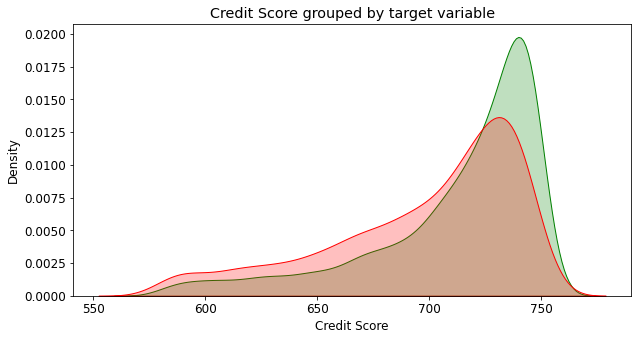

In [99]:
# Рассмотрим призник Credit Scortе
credit_score_with_target = train_df[['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

In [100]:
# Гипотеза
#     Нулевая гипотеза: средние значения в двух независимых выборках равны
#     Альтернативная гипотеза: средние значения в двух независимых выборках различаются
#     Критерий: критерий Стьюдента (t-тест) и его аналоги
#     Уровень значимости 𝛼: 0.05

In [101]:
train_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Maximum Open Credit_outlier,Current Loan Amount_outlier,Current Credit Balance_outlier,Monthly Debt_outlier
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.604533,1.325286e+06,6.084133,0.030133,11.130933,18.317467,5.817764e+05,0.170000,15.815200,0.116933,0.552400,0.259200,309088.029067,258973.176800,18327.315333,707.735333,0.281733,0.207600,0.049467,0.544133,0.207600,0.050133,0.116000,0.050000,0.000800
std,0.649047,7.567551e+05,3.640717,0.271604,4.908924,7.041946,3.983164e+05,0.498598,22.649441,0.346904,1.551293,0.438225,171393.740131,189854.014316,11915.669777,40.371682,0.449874,0.405616,0.216855,0.498082,0.405616,0.218235,0.320246,0.217959,0.028275
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,7.123600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,11242.000000,11970.000000,17.000000,580.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.989635e+05,0.000000,0.000000,0.000000,0.000000,0.000000,180169.000000,122564.250000,10102.750000,689.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,309567.500000,209323.000000,16077.250000,722.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.502330e+05,0.000000,29.000000,0.000000,0.000000,1.000000,396929.500000,338314.000000,23818.000000,738.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,2.234056e+06,7.000000,118.000000,4.000000,14.000000,1.000000,789030.000000,997899.000000,136679.000000,751.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
# Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка
shapiro(credit_score)

ShapiroResult(statistic=0.8493130803108215, pvalue=0.0)

In [103]:
# По полученному значению p-value, которое сильно меньше 0.05, можем заключить, 
# что гипотеза о "нормальности" отвергается.

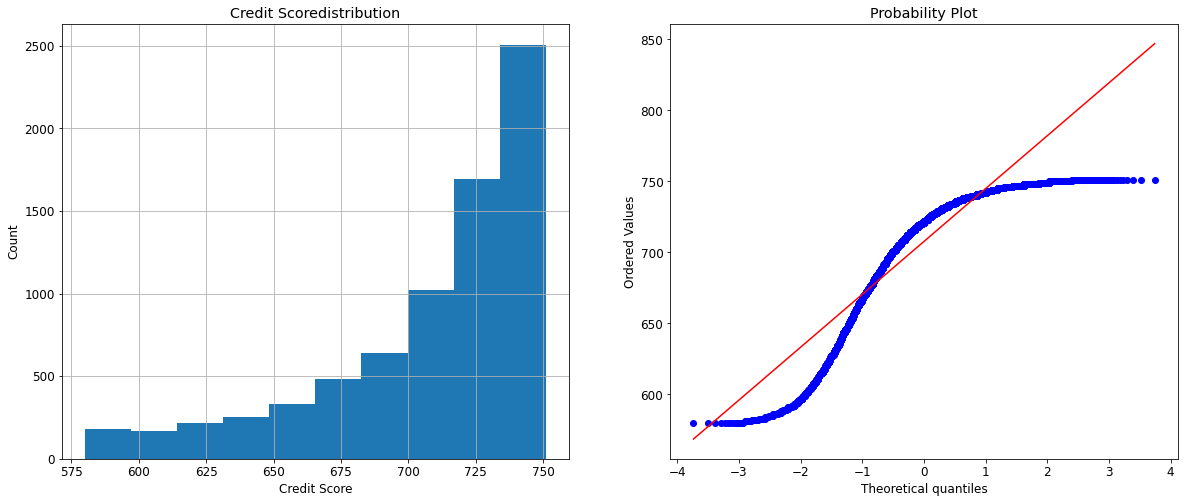

In [104]:
# Для достоверности произведём визуальную оценку распределения признака, 
# а так же построим QQ-график

plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Scoredistribution')
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

plt.show()

In [105]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=7073251.5, pvalue=2.486786015445818e-60)

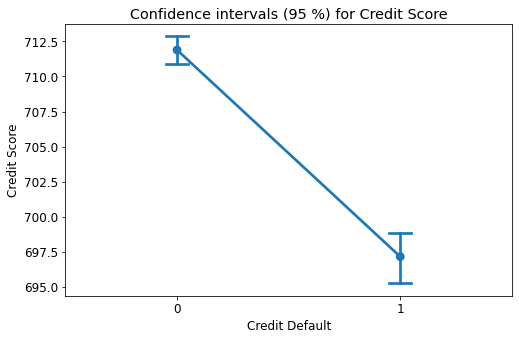

In [106]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

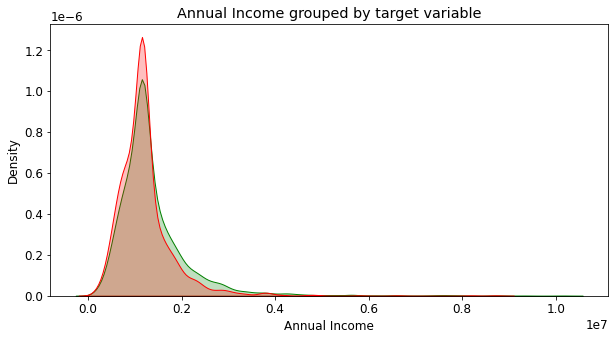

In [107]:
# Рассмотрим призник Annual Income
annual_income_with_target = train_df[['Annual Income', TARGET_NAME]]
annual_income = annual_income_with_target['Annual Income']
annual_income_target_0 = annual_income[annual_income_with_target[TARGET_NAME] == 0]
annual_income_target_1 = annual_income[annual_income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

In [108]:
# Гипотеза
#     Нулевая гипотеза: средние значения в двух независимых выборках равны
#     Альтернативная гипотеза: средние значения в двух независимых выборках различаются
#     Критерий: критерий Стьюдента (t-тест) и его аналоги
#     Уровень значимости 𝛼: 0.05

In [109]:
# Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка
shapiro(annual_income)

ShapiroResult(statistic=0.7313876152038574, pvalue=0.0)

In [110]:
# По полученному значению p-value, которое сильно меньше 0.05, можем заключить, 
# что гипотеза о "нормальности" отвергается.

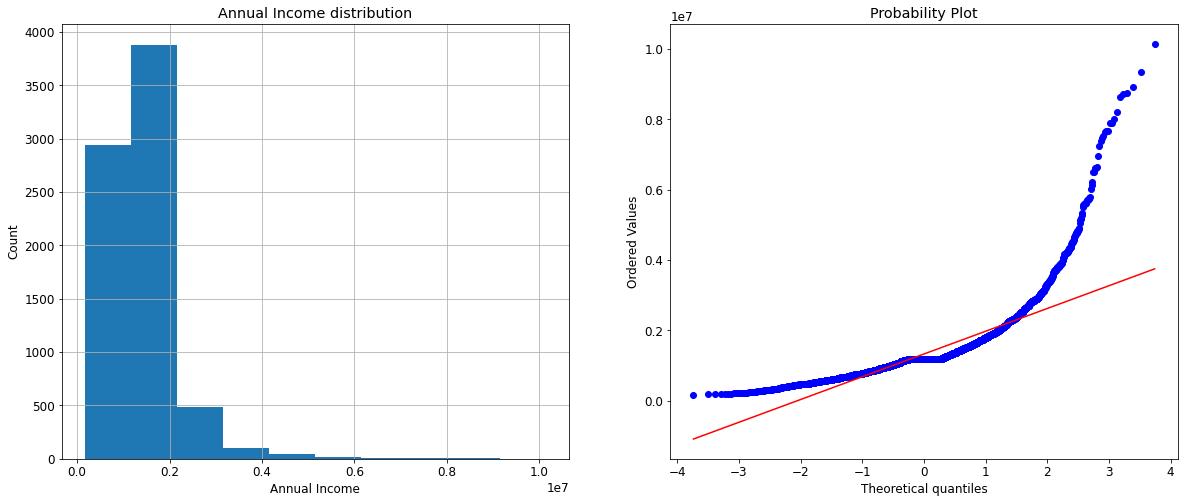

In [111]:
# Для достоверности произведём визуальную оценку распределения признака, 
# а так же построим QQ-график

plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income.hist()

plt.subplot(122)
probplot(annual_income, dist='norm', plot=plt)

plt.show()

In [112]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=6398267.5, pvalue=3.8213385688829025e-17)

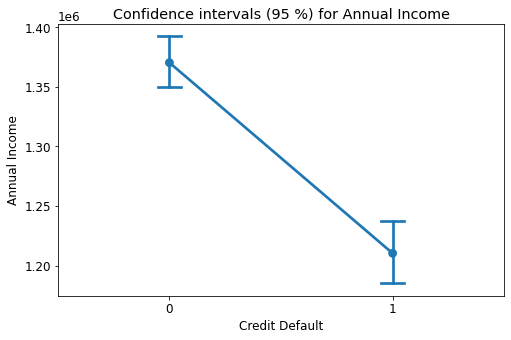

In [113]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

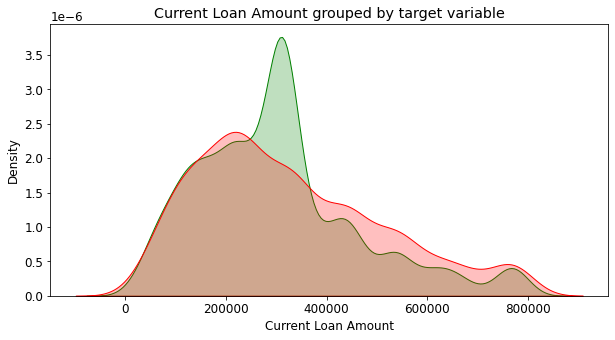

In [114]:
# Рассмотрим призник Annual Income
current_loan_amount_with_target = train_df[['Current Loan Amount', TARGET_NAME]]
current_loan_amount = current_loan_amount_with_target['Current Loan Amount']
current_loan_amount_target_0 = current_loan_amount[current_loan_amount_with_target[TARGET_NAME] == 0]
current_loan_amount_target_1 = current_loan_amount[current_loan_amount_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(current_loan_amount_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(current_loan_amount_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

In [115]:
# Гипотеза
#     Нулевая гипотеза: средние значения в двух независимых выборках равны
#     Альтернативная гипотеза: средние значения в двух независимых выборках различаются
#     Критерий: критерий Стьюдента (t-тест) и его аналоги
#     Уровень значимости 𝛼: 0.05

In [116]:
# Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка
shapiro(current_loan_amount)

ShapiroResult(statistic=0.9422052502632141, pvalue=0.0)

In [117]:
# По полученному значению p-value, которое сильно меньше 0.05, можем заключить, 
# что гипотеза о "нормальности" отвергается.

In [118]:
# Для достоверности произведём визуальную оценку распределения признака, 
# а так же построим QQ-график

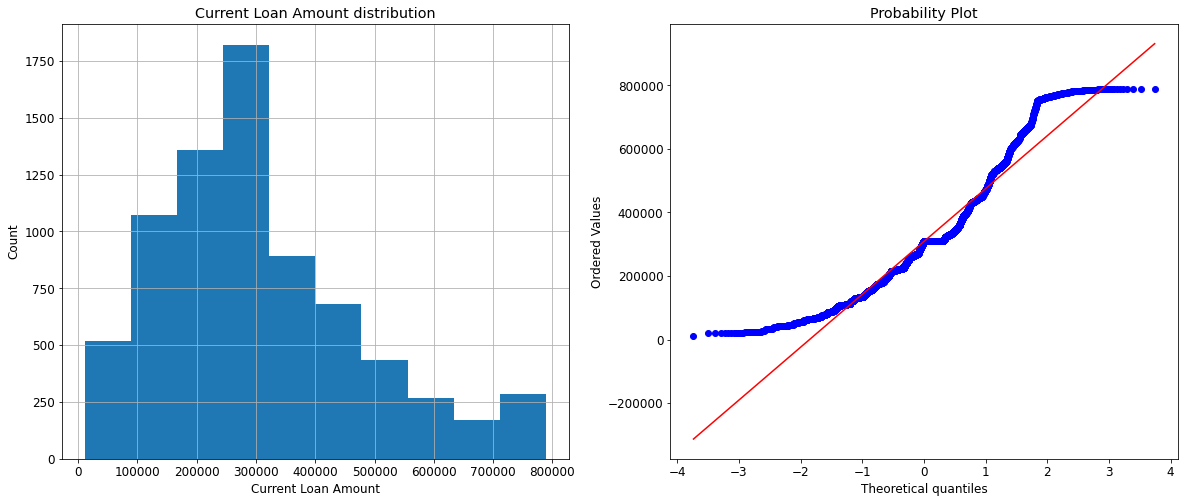

In [119]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
current_loan_amount.hist()

plt.subplot(122)
probplot(current_loan_amount, dist='norm', plot=plt)

plt.show()

In [120]:
mannwhitneyu(current_loan_amount_target_0, current_loan_amount_target_1)

MannwhitneyuResult(statistic=5333033.0, pvalue=2.124323817669743e-05)

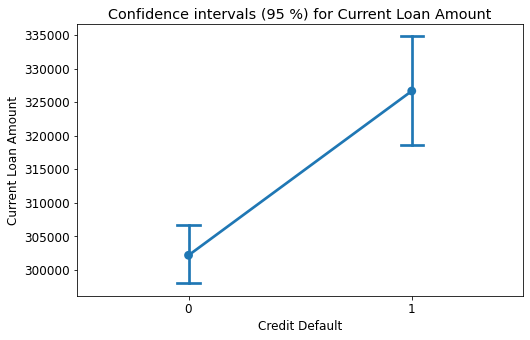

In [121]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=current_loan_amount_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

### Анализ признакового пространства

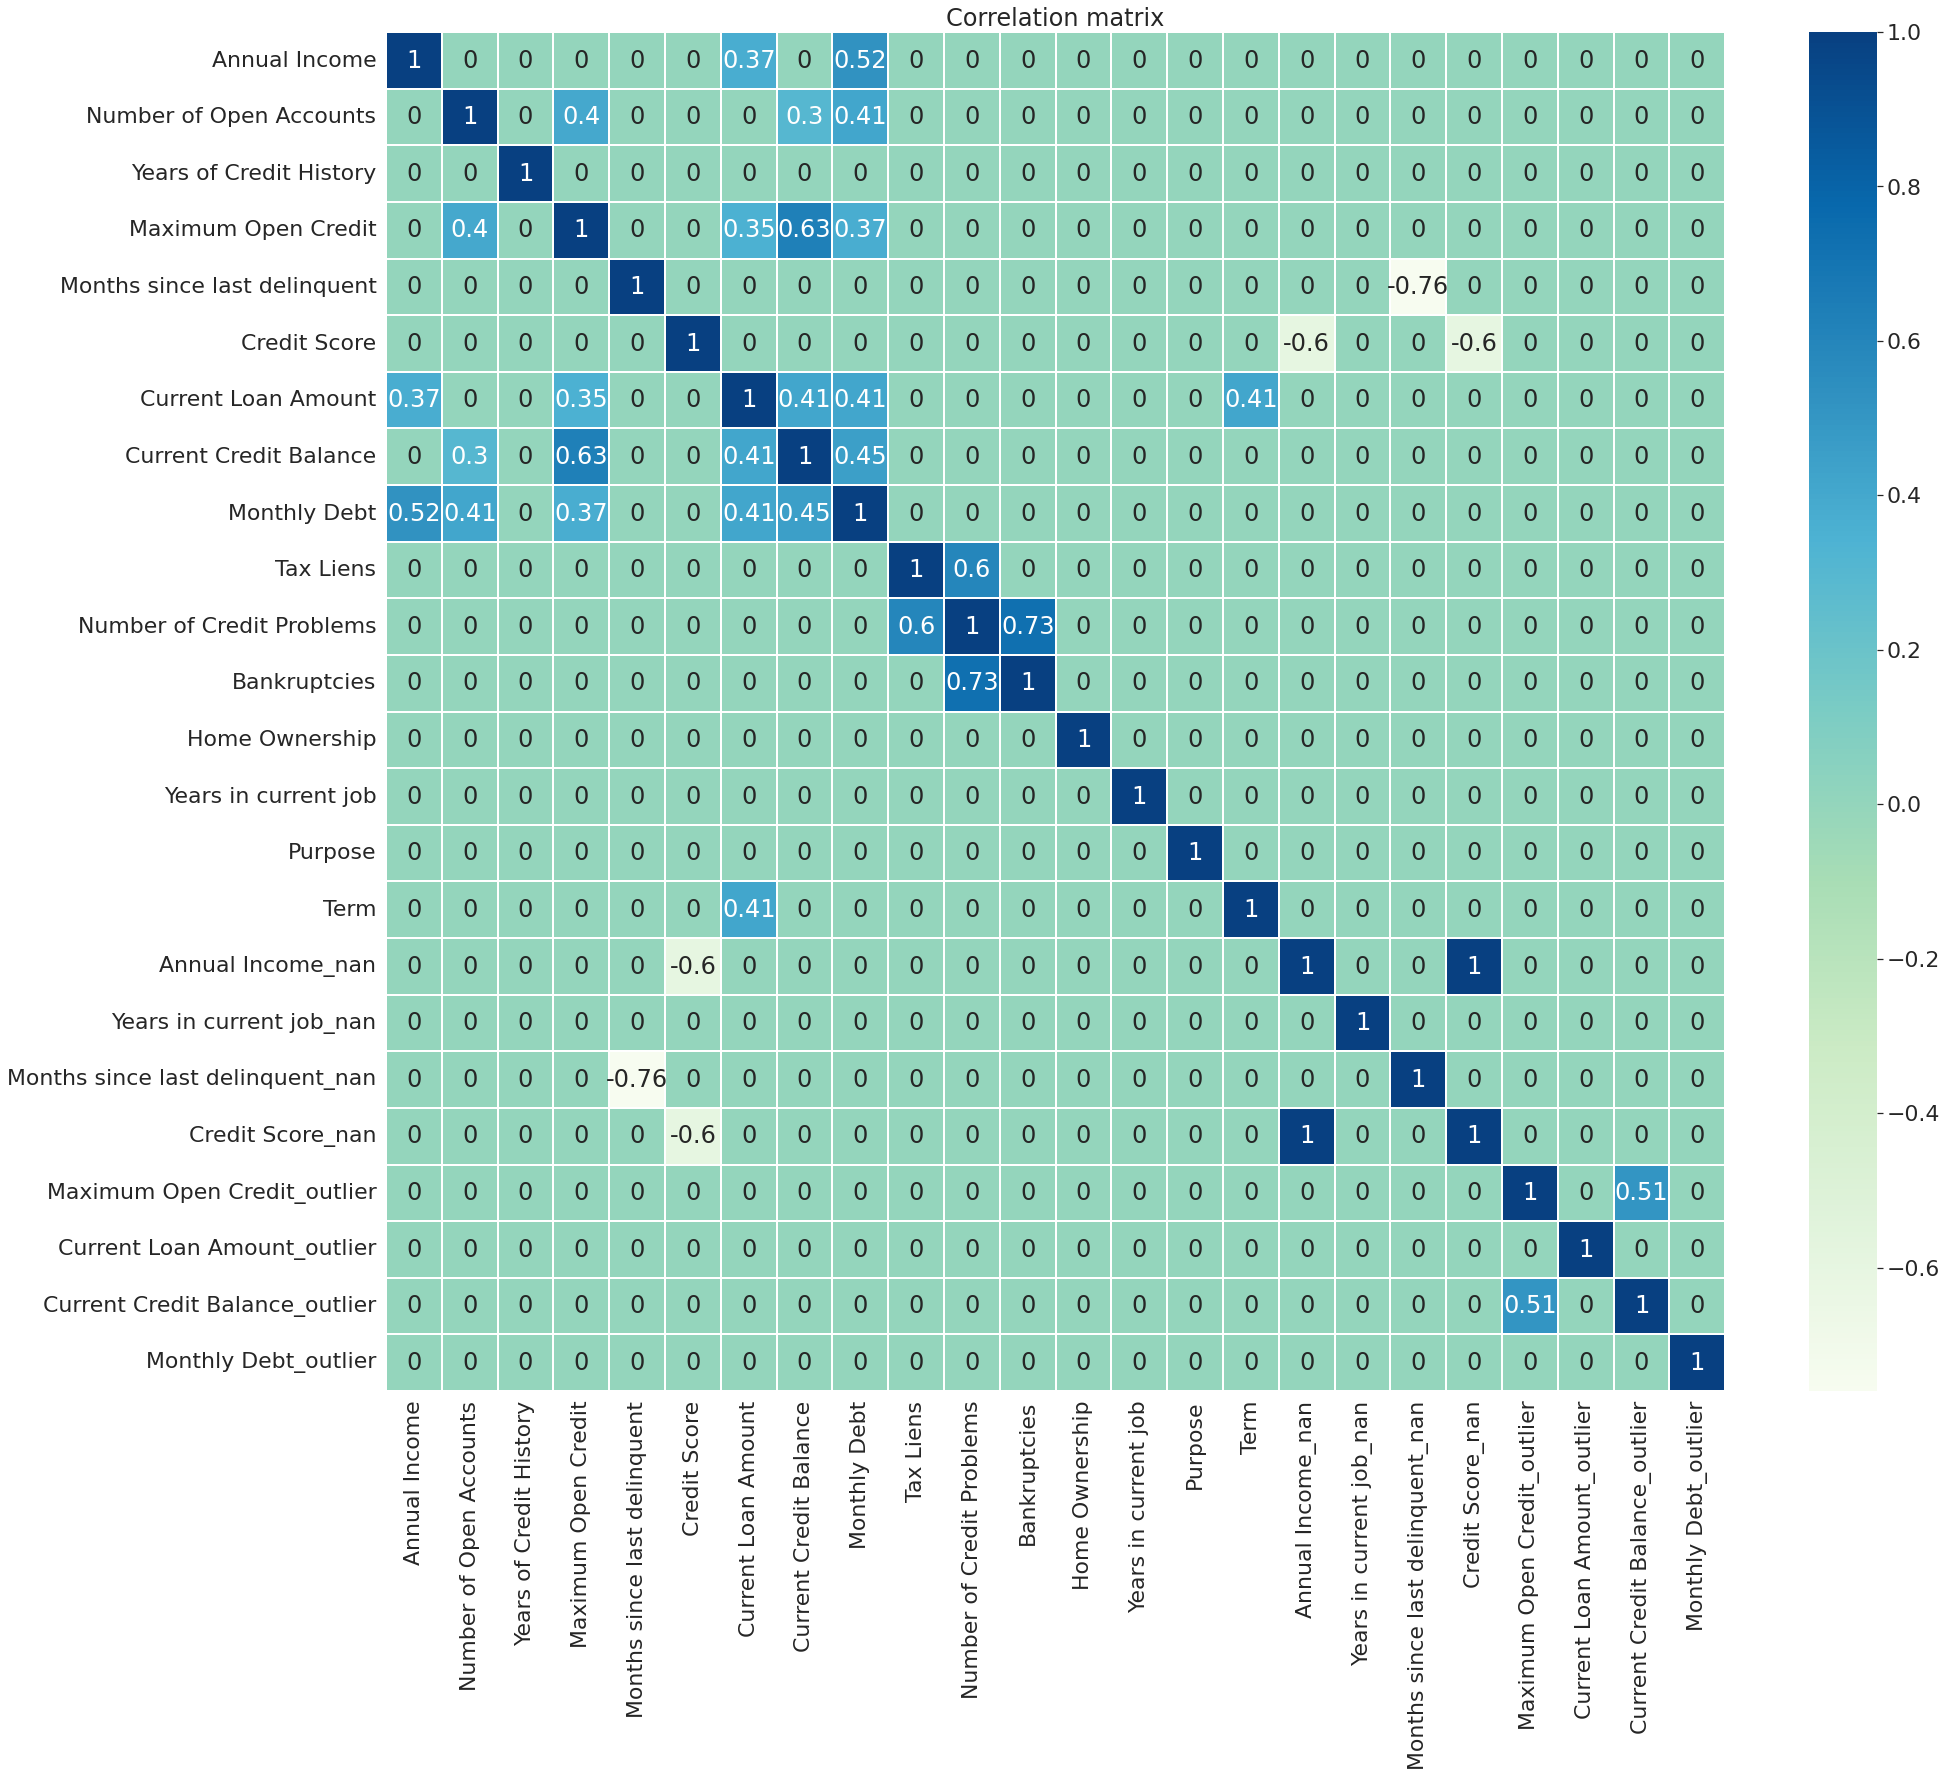

In [122]:
plt.figure(figsize=(30, 25))

sns.set(font_scale=2)

corr_matrix = train_df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.1, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Проверим распределения вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9361624.5, pvalue=0.9144137159274787)


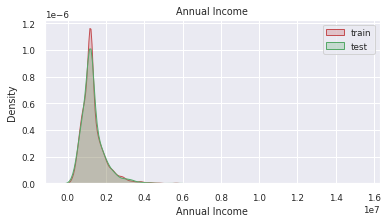

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.4428527435772891)


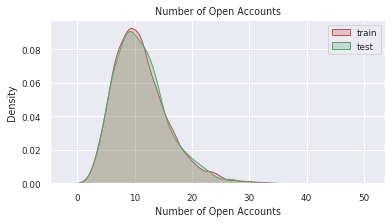

Years of Credit History
MannwhitneyuResult(statistic=9410342.0, pvalue=0.7773891904970164)


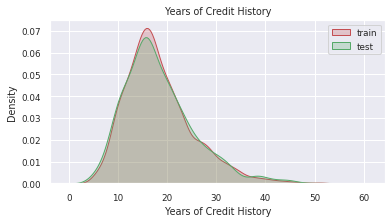

Maximum Open Credit
MannwhitneyuResult(statistic=9384428.5, pvalue=0.9398729321340588)


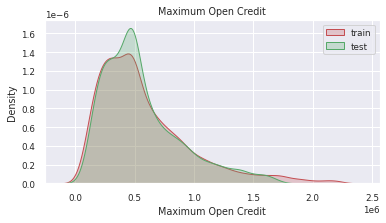

Months since last delinquent
MannwhitneyuResult(statistic=9403801.5, pvalue=0.8011421747219063)


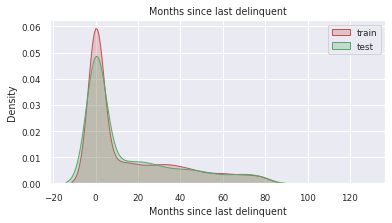

Credit Score
MannwhitneyuResult(statistic=7871110.0, pvalue=2.37457235491112e-33)


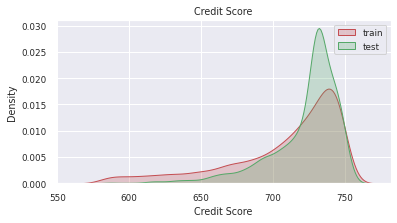

Current Loan Amount
MannwhitneyuResult(statistic=9588453.5, pvalue=0.08761005826486847)


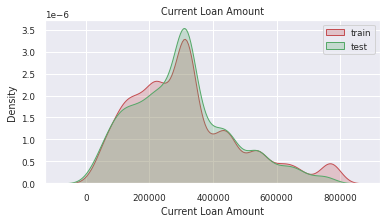

Current Credit Balance
MannwhitneyuResult(statistic=9332565.0, pvalue=0.7342313711192714)


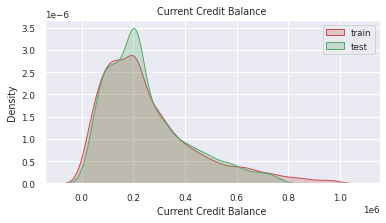

Monthly Debt
MannwhitneyuResult(statistic=9295435.0, pvalue=0.5244608891321795)


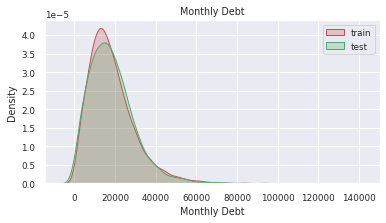

In [123]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

**Проверим распределения категориальных признаков на трейне и тесте**

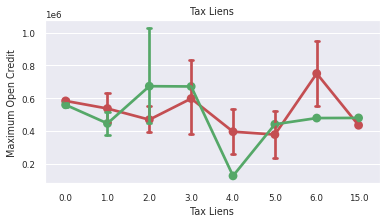

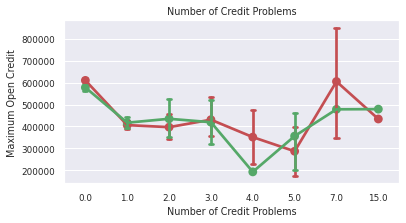

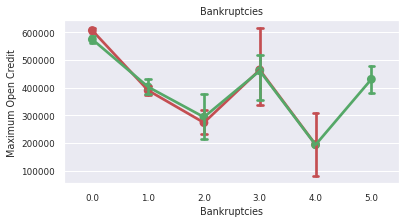

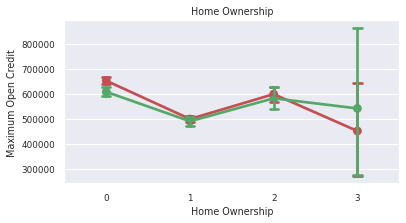

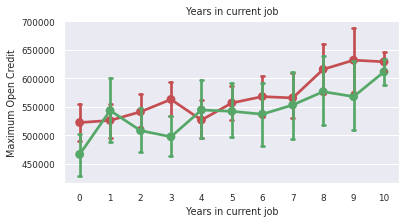

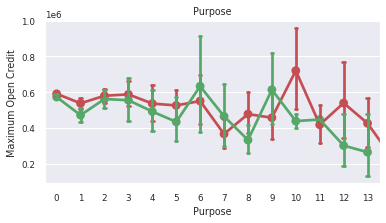

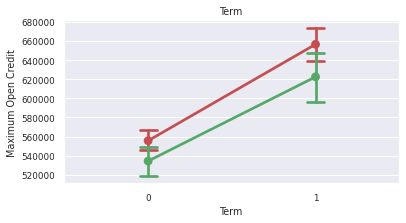

In [124]:
num_feature = 'Maximum Open Credit'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train_df', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test_df', color='g')
    plt.title(col) 
    plt.show()

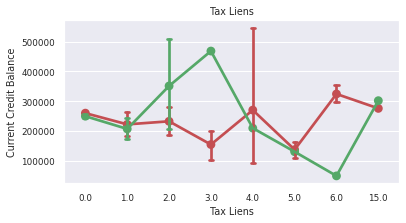

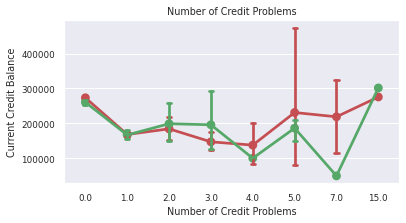

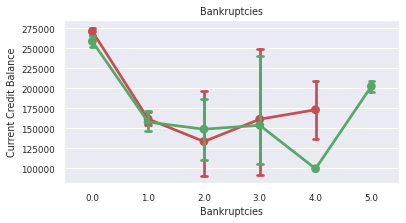

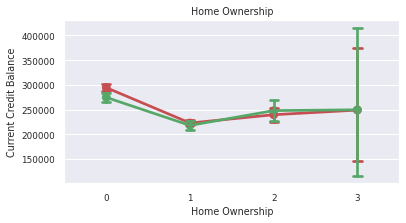

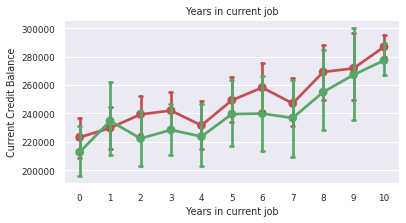

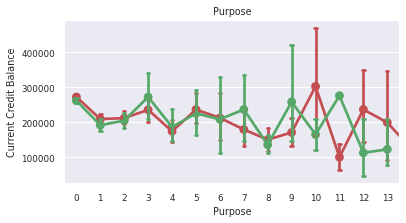

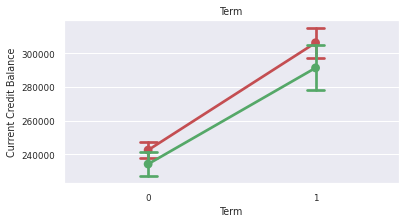

In [125]:
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train_df', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test_df', color='g')
    plt.title(col) 
    plt.show()

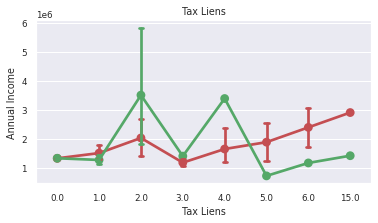

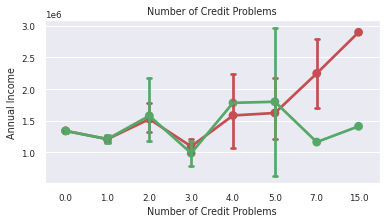

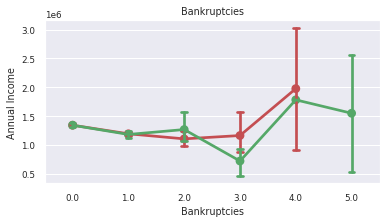

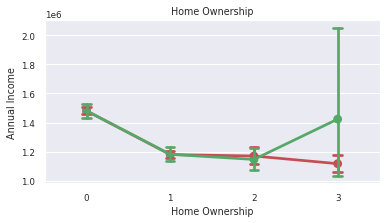

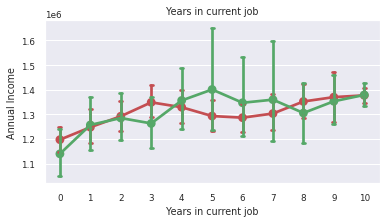

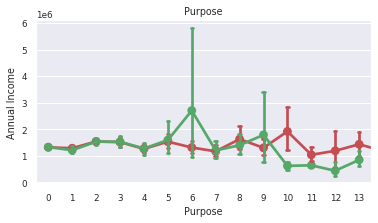

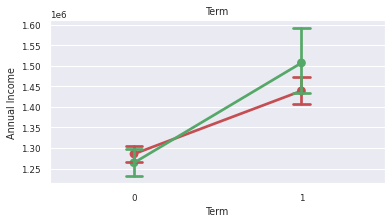

In [126]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train_df', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test_df', color='g')
    plt.title(col) 
    plt.show()

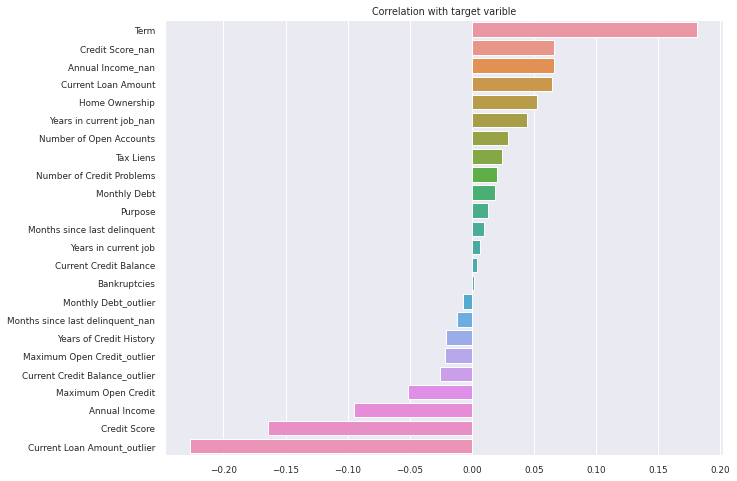

In [127]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target varible')
plt.show()

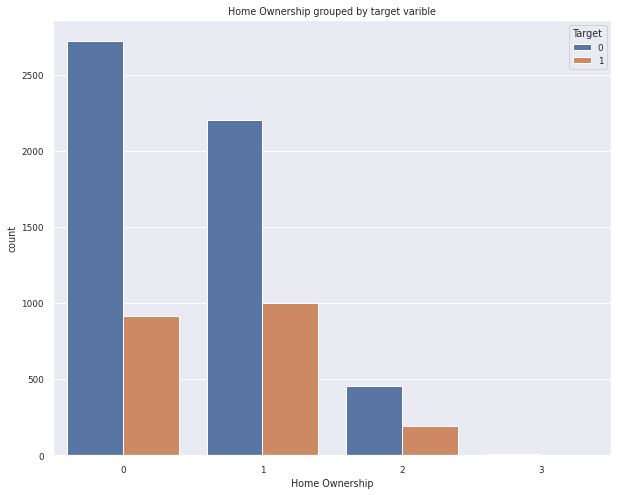

In [128]:
# Оценка призника Home Ownership в разрезе целевой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x='Home Ownership', hue=TARGET_NAME, data=train_df)
plt.title('Home Ownership grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [129]:
# Расчитаем наблюдаемые частоты 0 и 1
train_df['Id'] = train_df.index
home_owership_target_s = train_df.loc[train_df['Home Ownership'].isin([0, 1]),\
                                      ['Id', 'Home Ownership','Credit Default']]

In [130]:
table = home_owership_target_s.pivot_table(values='Id', 
                                           index='Home Ownership',
                                           columns='Credit Default',
                                           aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
0,2721,916
1,2201,1003


In [131]:
#Проверим нашу гипотезу, используя критерий Хи-квадрат Пирсона

In [132]:
chi2, p, _, _ = chi2_contingency(table)
p

2.2122322110125114e-08

In [133]:
#Объеденим 0 и 1 категорию т.к p выше % 

In [134]:
train_df['Home Ownership'] = train_df['Home Ownership'].replace({1: 0})
                                                                     

In [135]:
# Расчитаем наблюдаемые частоты 2 и 3
train_df['Id'] = train_df.index
home_owership_target_s = train_df.loc[train_df['Home Ownership'].isin([0, 1]), ['Id', 'Home Ownership', \
                                                                   'Credit Default']]

table = home_owership_target_s.pivot_table(values='Id', 
                                           index='Home Ownership',
                                           columns='Credit Default',
                                           aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
0,4922,1919


In [136]:
chi2, p, _, _ = chi2_contingency(table)
p

1.0

In [137]:
#Объеденим 2 и 3 категорию т.к p выше %

In [138]:
train_df['Home Ownership'] = train_df['Home Ownership'].replace({2: 1, 3: 1})

In [139]:
train_df['Home Ownership'].value_counts()

0    6841
1     659
Name: Home Ownership, dtype: int64

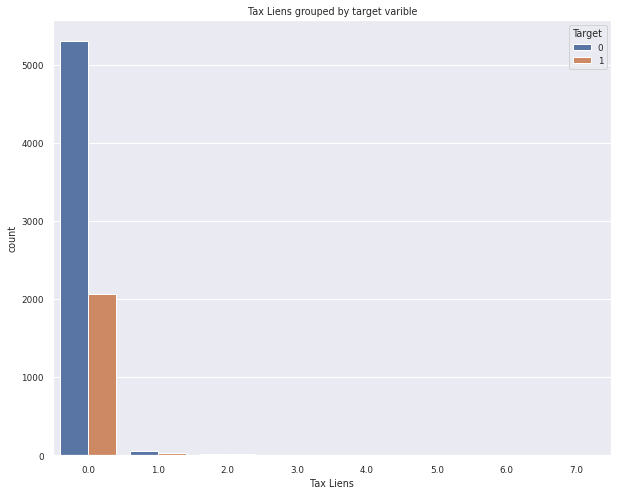

In [140]:
# Оценка призника Tax Liens в разрезе целевой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x='Tax Liens', hue=TARGET_NAME, data=train_df)
plt.title('Tax Liens grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [141]:
# Расчитаем наблюдаемые частоты 
train_df['Id'] = train_df.index
tax_liens_target_s = train_df.loc[train_df['Tax Liens'].isin([0, 1]), ['Id', 'Tax Liens', \
                                                                   'Credit Default']]

table = tax_liens_target_s.pivot_table(values='Id', 
                                           index='Tax Liens',
                                           columns='Credit Default',
                                           aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.956212700856196

In [142]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [143]:
# Согласно оценки критерий Хи-квадрат Пирсона (Tax Liens):

# 0 и 1 p = 0,95 ;
# 2 и 3 p = 1 ;
# 3 и 4 p = 1 ;
# 4 и 5 p = 1 ; 
# 5 и 6 p = nan ;
# 6 и 7 p = 1 

# Таким образом можем обеденить след категории:  0кат = 0 + 1;
#                                                1кат = 2 + 3 + 4 + 5; 
#                                                2кат = 6 + 7   

train_df['Tax Liens'] = train_df['Tax Liens'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2})

In [144]:
train_df['Tax Liens'].value_counts()

0.0    7449
1.0      48
2.0       3
Name: Tax Liens, dtype: int64

In [145]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

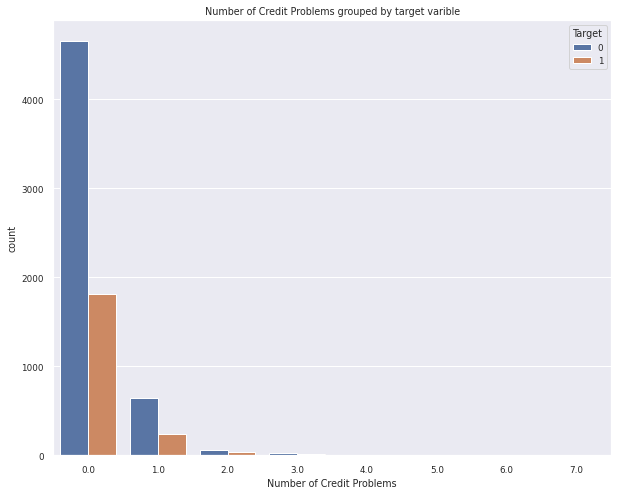

In [146]:
# Оценка призника Number of Credit Problems в разрезе целевой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x='Number of Credit Problems', hue=TARGET_NAME, data=train_df)
plt.title('Number of Credit Problems grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [147]:
# Расчитаем наблюдаемые частоты 
train_df['Id'] = train_df.index
number_of_credit_problems_target_s = train_df.loc[train_df['Number of Credit Problems'].isin([2, 3]), ['Id', 'Number of Credit Problems', \
                                                                   'Credit Default']]

table = number_of_credit_problems_target_s.pivot_table(values='Id', 
                                           index='Number of Credit Problems',
                                           columns='Credit Default',
                                           aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.789656113587645

In [148]:
# Согласно оценки критерий Хи-квадрат Пирсона (Number of Credit Problems):

# 0 и 1 p = 0,68 ;
# 1 и 2 p = 0,12
# 2 и 3 p = 0.78 ;
# 3 и 4 p = 0.29 ;
# 3 и 5 p = 0.675 ;
# 4 и 5 p = 1 ; 
# 5 и 6 p = nan ;
# 6 и 7 p = 1 

# Таким образом можем обеденить след категории:  0кат = 0 + 1;
#                                                1кат = 2 + 3 + 5; 
#                                                2кат = 4;
#                                                3кат = 6+7;


train_df['Number of Credit Problems'] =\
train_df['Number of Credit Problems'].replace({1: 0, 2: 1, 3: 1, 4: 2, 5: 1, 6: 3, 7: 3})

In [149]:
train_df['Number of Credit Problems'].value_counts()

0.0    7351
1.0     135
2.0       9
3.0       5
Name: Number of Credit Problems, dtype: int64

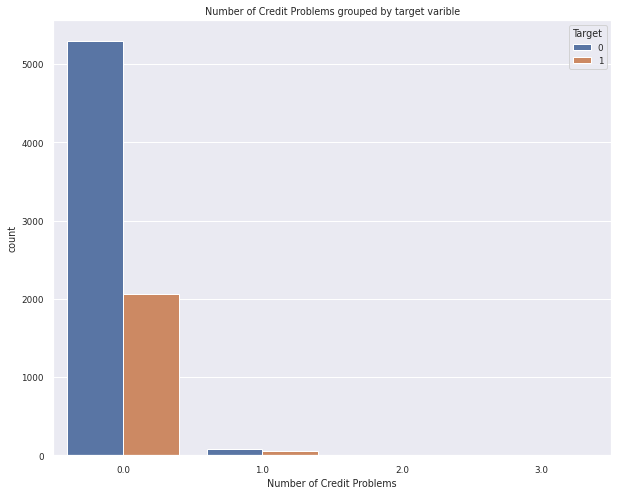

In [150]:
# Оценка призника Number of Credit Problems в разрезе целевой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x='Number of Credit Problems', hue=TARGET_NAME, data=train_df)
plt.title('Number of Credit Problems grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

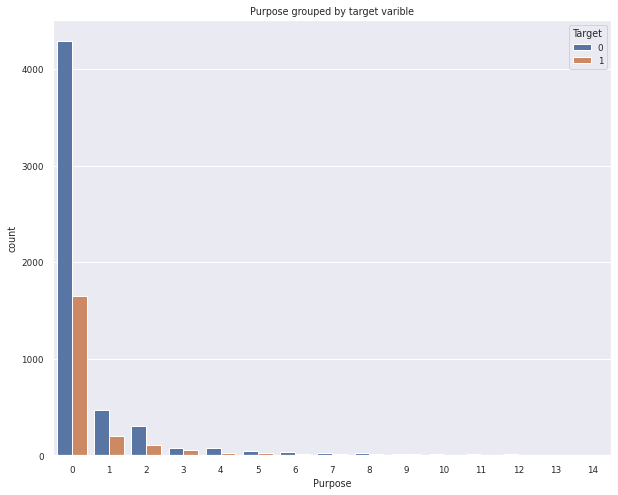

In [151]:
# Оценка призника Purpose в разрезе целевой переменной
plt.figure(figsize=(10, 8))

sns.countplot(x='Purpose', hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [152]:
# Расчитаем наблюдаемые частоты Purpose
train_df['Id'] = train_df.index
purpose_target_s = train_df.loc[train_df['Purpose'].isin([5, 1]), ['Id', 'Purpose', 'Credit Default']]

table = purpose_target_s.pivot_table(values='Id', 
                                           index='Purpose',
                                           columns='Credit Default',
                                           aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.918726076937743

In [153]:
# Согласно оценки критерий Хи-квадрат Пирсона (Purpose):

# p > 0.5
# Таким образом можем обеденить след категории:  0кат = 2 + 4 + 6 + 7 + 8 + 10 + 11 + 12 + 13;
#                                                1кат = 1 + 5; 
#                                                2кат = 3;
#                                                3кат = 9;
#                                                4кат = 14;

train_df['Purpose'] =\
train_df['Purpose'].replace({2: 0, 4: 0, 6: 0, 7: 0, 8: 0, 10: 0, 11: 0, 12: 0, 13:0, 3: 2, 5: 1, 9: 3, 14: 4})

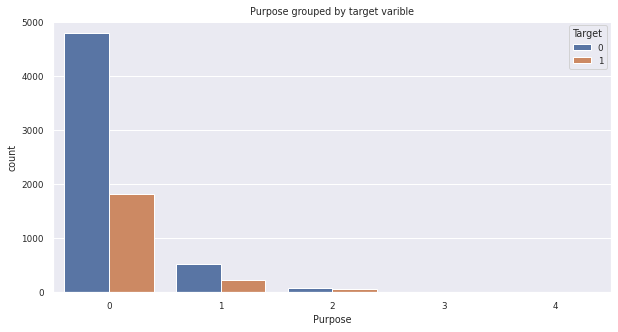

In [154]:
# Оценка призника Purpose в разрезе целевой переменной
plt.figure(figsize=(10, 5))

sns.countplot(x='Purpose', hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [155]:
train_df['Purpose'].value_counts()

0    6607
1     736
2     129
3      26
4       2
Name: Purpose, dtype: int64

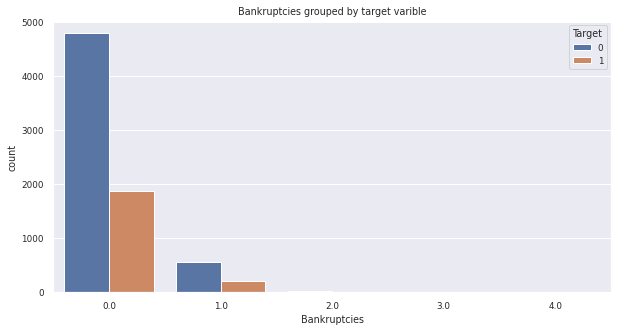

In [156]:
# Оценка призника Purpose в разрезе целевой переменной
plt.figure(figsize=(10, 5))

sns.countplot(x='Bankruptcies', hue=TARGET_NAME, data=train_df)
plt.title('Bankruptcies grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [157]:
train_df['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [158]:
# Расчитаем наблюдаемые частоты Bankruptcies
train_df['Id'] = train_df.index
bankruptcies_target_s = train_df.loc[train_df['Bankruptcies'].isin([0, 1]), ['Id', 'Bankruptcies', 'Credit Default']]

table = bankruptcies_target_s.pivot_table(values='Id', 
                                           index='Bankruptcies',
                                           columns='Credit Default',
                                           aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.7592266602852901

In [159]:
# Согласно оценки критерий Хи-квадрат Пирсона (Bankruptcies):

# p > 0.5
# Таким образом можем обеденить след категории:  0кат = 1 + 3 + 4 ;
#                                                1кат = 2; 
                                           

train_df['Bankruptcies'] =\
train_df['Bankruptcies'].replace({1: 0, 3: 0, 4: 0, 2: 1})

In [160]:
train_df['Bankruptcies'].value_counts()

0.0    7469
1.0      31
Name: Bankruptcies, dtype: int64

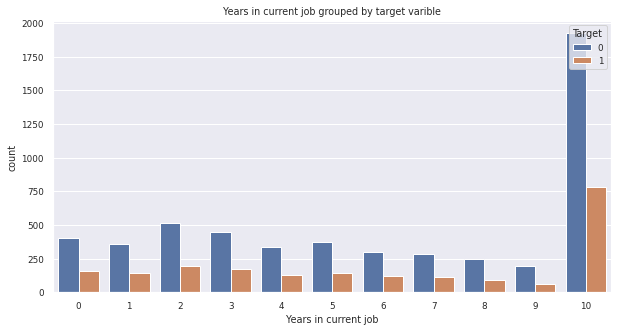

In [161]:
# Оценка призника Years in current job в разрезе целевой переменной
plt.figure(figsize=(10, 5))

sns.countplot(x='Years in current job', hue=TARGET_NAME, data=train_df)
plt.title('Years in current job grouped by target varible')
plt.legend(title='Target', loc='upper right')

plt.show()

In [162]:
train_df['Years in current job'].value_counts()

10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

In [163]:
# Расчитаем наблюдаемые частоты Years in current job
train_df['Id'] = train_df.index
years_in_current_job_target_s = train_df.loc[train_df['Years in current job'].isin([10, 0]), ['Id', 'Years in current job', 'Credit Default']]

table = years_in_current_job_target_s.pivot_table(values='Id', 
                                           index='Years in current job',
                                           columns='Credit Default',
                                           aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.7950020806545707

In [164]:
# По признаку Years in current job не представляется возможным
# произвести объединение по Хи квадрат, применим логическое распределение 
# 0 - 1 лет = 0 кат; 2 - 5 лет = 1 кат; 6 - 9 лет = 2 кат ; 10 = 3 кат

train_df['Years in current job'] =\
train_df['Years in current job'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2, 10: 3})

In [165]:
train_df['Years in current job'].value_counts()

3    2703
1    2310
2    1420
0    1067
Name: Years in current job, dtype: int64

In [166]:
train_df['Home Ownership'].value_counts()

0    6841
1     659
Name: Home Ownership, dtype: int64

### ПРОВЕРКА РАБОТЫ КЛАССОВ

In [167]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH,sep=',')

In [168]:
preprocessor_pass = PassProcessing()
preprocessor_pass.fit(train_df)

train_df = preprocessor_pass.transform(train_df)
test_df = preprocessor_pass.transform(test_df)

In [169]:
features_gen = FeatureGenetator()
features_gen.fit(test_df)

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

In [170]:
features_gen_hiq = FeatureGenetatorHIQ()
features_gen_hiq.fit(test_df)

train_df = features_gen_hiq.transform(train_df)
test_df = features_gen_hiq.transform(test_df)

In [171]:
preprocessor_outlier = ProcessingOutliers()
preprocessor_outlier.fit(train_df)

train_df = preprocessor_outlier.transform(train_df)
test_df = preprocessor_outlier.transform(test_df)

In [172]:
test_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Credit Score_cat,Maximum Open Credit_outlier,Current Loan Amount_outlier,Current Credit Balance_outlier,Monthly Debt_outlier,Credit Score_outlier
count,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.0,2500.000000
mean,0.102000,1.326182e+06,1.766000,0.010000,11.184400,18.325920,5.852591e+05,0.024000,15.614000,0.006000,0.136800,0.255600,312497.024400,258194.610000,18271.340000,721.893200,0.205200,0.034400,0.54320,0.205200,3.39520,0.050400,0.118800,0.056000,0.0,0.064000
std,0.302709,8.215127e+05,1.088356,0.307795,4.852774,7.254659,4.069062e+05,0.332668,22.616348,0.148232,0.392616,0.436285,171474.128879,186430.862384,11543.881469,25.144962,0.403928,0.182291,0.49823,0.403928,1.07195,0.218813,0.323618,0.229968,0.0,0.244802
min,0.000000,1.065330e+05,0.000000,0.000000,1.000000,3.900000,7.194000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,15422.000000,12084.000000,93.000000,585.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,9.365622e+05,1.000000,0.000000,8.000000,13.400000,2.939255e+05,0.000000,0.000000,0.000000,0.000000,0.000000,187126.500000,121752.000000,10024.750000,714.000000,0.000000,0.000000,0.00000,0.000000,3.00000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,1.168386e+06,2.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,309573.000000,209323.000000,16642.500000,731.000000,0.000000,0.000000,1.00000,0.000000,4.00000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,1.488726e+06,3.000000,0.000000,14.000000,22.100000,7.549080e+05,0.000000,27.000000,0.000000,0.000000,1.000000,398893.000000,340299.500000,24146.000000,738.000000,0.000000,0.000000,1.00000,0.000000,4.00000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.497561e+07,3.000000,15.000000,48.000000,53.400000,2.221230e+06,15.000000,82.000000,5.000000,3.000000,1.000000,789096.000000,997557.000000,93555.000000,751.000000,1.000000,1.000000,1.00000,1.000000,4.00000,1.000000,1.000000,1.000000,0.0,1.000000


In [173]:
train_df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_nan,Years in current job_nan,Months since last delinquent_nan,Credit Score_nan,Credit Score_cat,Maximum Open Credit_outlier,Current Loan Amount_outlier,Current Credit Balance_outlier,Monthly Debt_outlier,Credit Score_outlier
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.087867,1.325286e+06,1.767867,0.007200,11.130933,18.317467,5.817764e+05,0.022400,15.815200,0.004133,0.144000,0.259200,309088.029067,258973.176800,18327.315333,722.352533,0.281733,0.207600,0.049467,0.544133,0.207600,3.441067,0.050133,0.116000,0.050000,0.000800,0.053333
std,0.283120,7.567551e+05,1.087998,0.089158,4.908924,7.041946,3.983164e+05,0.168232,22.649441,0.064162,0.426249,0.438225,171393.740131,189854.014316,11915.669777,25.276816,0.449874,0.405616,0.216855,0.498082,0.405616,1.017971,0.218235,0.320246,0.217959,0.028275,0.224712
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,7.123600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,11242.000000,11970.000000,17.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.311330e+05,1.000000,0.000000,8.000000,13.500000,2.989635e+05,0.000000,0.000000,0.000000,0.000000,0.000000,180169.000000,122564.250000,10102.750000,715.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.168386e+06,2.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,309567.500000,209323.000000,16077.250000,731.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.499974e+06,3.000000,0.000000,14.000000,21.800000,7.502330e+05,0.000000,29.000000,0.000000,0.000000,1.000000,396929.500000,338314.000000,23818.000000,738.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.014934e+07,3.000000,2.000000,43.000000,57.700000,2.234056e+06,3.000000,118.000000,1.000000,4.000000,1.000000,789030.000000,997899.000000,136679.000000,751.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Выделение целевой переменной и групп признаков**

In [174]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = [
                     'Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                     'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount',
                     'Credit Score', 'Months since last delinquent','Maximum Open Credit', 
                    ]


CAT_FEATURE_NAMES = [
    'Tax Liens',
                     'Home Ownership','Years in current job', 'Purpose', 'Term',
                     'Credit Score_cat',
     'Bankruptcies',  'Number of Credit Problems',
]

# CAT_FEATURE_NAMES = [
#                      'Tax Liens', 'Bankruptcies',    'Home Ownership'
#                  'Years in current job','Term',
#                      'Credit Score_cat',
#                      'Number of Credit Problems',
#                      'Purpose'
#                     ]


NAN_OUTLIER_FEATURE_NAMES = [
                        'Annual Income_nan', 'Years in current job_nan', 
                        'Months since last delinquent_nan', 'Credit Score_nan', 
                        'Maximum Open Credit_outlier', 
                        'Current Credit Balance_outlier', 'Monthly Debt_outlier',
                        'Credit Score_outlier',
#                         'Current Loan Amount_outlier',
                            ]


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NAN_OUTLIER_FEATURE_NAMES

In [175]:
train_df[CAT_FEATURE_NAMES] = train_df[CAT_FEATURE_NAMES].astype('int8')
train_df[NAN_OUTLIER_FEATURE_NAMES] = train_df[NAN_OUTLIER_FEATURE_NAMES].astype('int8')

test_df[CAT_FEATURE_NAMES] = test_df[CAT_FEATURE_NAMES].astype('int8')
test_df[NAN_OUTLIER_FEATURE_NAMES] = test_df[NAN_OUTLIER_FEATURE_NAMES].astype('int8')

In [177]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Number of Open Accounts       7500 non-null   float64
 2   Years of Credit History       7500 non-null   float64
 3   Current Credit Balance        7500 non-null   float64
 4   Monthly Debt                  7500 non-null   float64
 5   Current Loan Amount           7500 non-null   float64
 6   Credit Score                  7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Maximum Open Credit           7500 non-null   float64
 9   Tax Liens                     7500 non-null   int8   
 10  Home Ownership                7500 non-null   int8   
 11  Years in current job          7500 non-null   int8   
 12  Purpose                       7500 non-null   int8   
 13  Ter

### Построение модели

In [176]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [178]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5502958579881656

In [179]:
model_catb = catb.CatBoostClassifier(
                                     silent=True, random_state=42,
                                     class_weights=[1, disbalance],
#                                      one_hot_max_size=15,
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=20,
                                     iterations=400, 
                                     max_depth=5,

                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
predictions = model_catb.predict(test_df[model_catb.feature_names_])
submit = pd.read_csv('sample_submission.csv')
submit['Credit Default'] = predictions
PREPARED_DATASET_PATH = 'train_prepared.csv'
submit.to_csv(PREPARED_DATASET_PATH, index=False)
submit['Credit Default'].value_counts()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4310
           1       0.55      0.62      0.58      1690

    accuracy                           0.75      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.76      0.75      0.75      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1077
           1       0.50      0.60      0.54       423

    accuracy                           0.72      1500
   macro avg       0.66      0.68      0.67      1500
weighted avg       0.74      0.72      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               821  256
1               169  254


0    1678
1     822
Name: Credit Default, dtype: int64

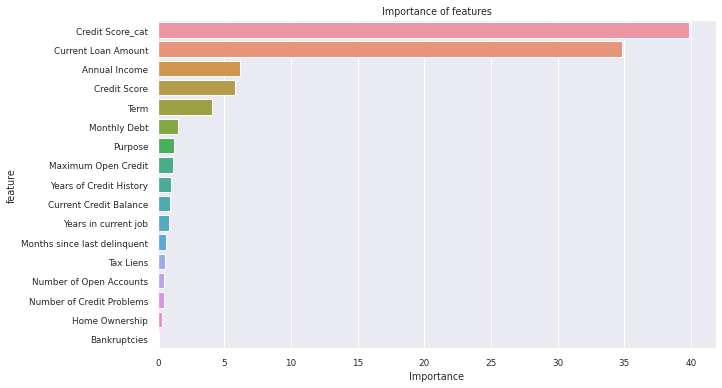

In [180]:
important_features_top = show_feature_importances(X_train.columns,
                                                  model_catb.feature_importances_, 
                                                  get_top=22)

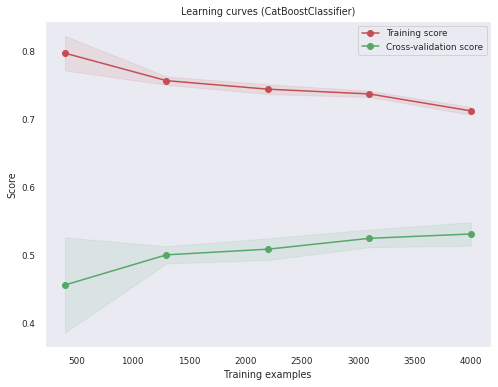

In [181]:
show_learning_curve_plot(model_catb, X_train, y_train)

### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [182]:
%%time

final_model = catb.CatBoostClassifier( 
                                     silent=True, random_state=42,
                                     class_weights=[1, disbalance],
                                     one_hot_max_size=9,
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=50,
                                     iterations=60, 
                                     max_depth=8,
                                     learning_rate=0.05,
                                     l2_leaf_reg=4,
                                    )

final_model.fit(X_train[SELECTED_FEATURE_NAMES], y_train, plot=True, eval_set=(X_test[SELECTED_FEATURE_NAMES], y_test))

evaluate_preds(final_model, X_train[SELECTED_FEATURE_NAMES], X_test[SELECTED_FEATURE_NAMES], y_train, y_test)
predictions = final_model.predict(test_df[final_model.feature_names_])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      4310
           1       0.56      0.60      0.58      1690

    accuracy                           0.75      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.76      0.75      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1077
           1       0.52      0.57      0.54       423

    accuracy                           0.73      1500
   macro avg       0.67      0.68      0.67      1500
weighted avg       0.74      0.73      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               853  224
1               183  240
CPU times: user 2.03 s, sys: 345 ms, total: 2.38 s
Wall time: 406 ms


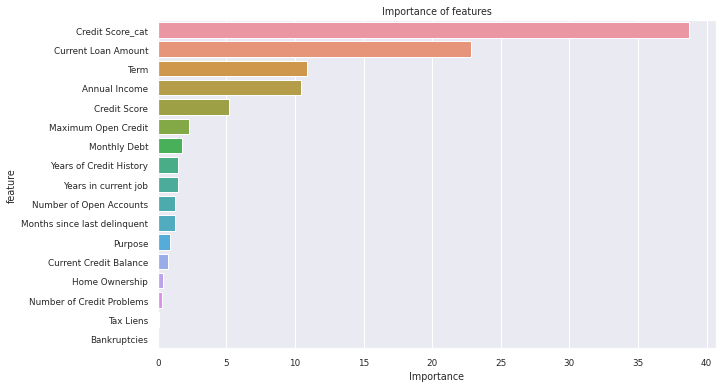

In [183]:
important_features_top = show_feature_importances(X_train.columns,
                                                  final_model.feature_importances_, 
                                                  get_top=22)

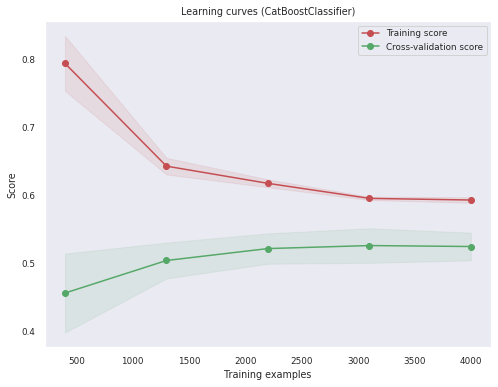

In [184]:
show_learning_curve_plot(final_model, X_train, y_train)

In [185]:
submit = pd.read_csv('sample_submission.csv')
submit['Credit Default'] = predictions
PREPARED_DATASET_PATH = 'train_prepared.csv'
submit.to_csv(PREPARED_DATASET_PATH, index=False,)
submit['Credit Default'].value_counts()

0    1736
1     764
Name: Credit Default, dtype: int64